In [1]:
import os
import shutil
import flopy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# ! Custom modules
from utils import pht3d_fsp
from utils.tools import calculate_MAS_sums, clear_directory
from utils.pht3d_utils import copy_pht3d_datab, run_pht3d_program

clear_directory()

In [2]:
data_folder = 'case13'
model_name = 'case13_modflow'
model_ws = './models_folder/' + data_folder

Lx = 0.053
Ly = 1.0

nrow = 1
ncol = 16
nlay = 1

delr = Lx / ncol
delc = Ly / nrow

top = 0.00287433
botm = 0.0

laytyp = 1

hk = 1.0

nper = 2
perlen = [0.9333333, 1.458333]
nstp = [64, 100]
steady = [True, True]

model = flopy.modflow.Modflow(modelname=model_name, model_ws=model_ws, exe_name='./bin/mf2005')
dis = flopy.modflow.ModflowDis(model, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=delr, delc=delc, top=top, botm=botm,
                               nper=nper, perlen=perlen, nstp=nstp, steady=steady)

ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[0, 0, -1] = -1
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
bas = flopy.modflow.ModflowBas(model, ibound=ibound, strt=strt)

lpf = flopy.modflow.ModflowLpf(model, hk=hk, laytyp=laytyp, ipakcb=53, ss=0)

chd_spd = {0: [[0, 0, ncol-1, 1.0, 1.0],]}
chd = flopy.modflow.ModflowChd(model, stress_period_data=chd_spd)

wel_spd = {0: [[0, 0, 0, 0.00024],],}
wel = flopy.modflow.ModflowWel(model, ipakcb=66, stress_period_data=wel_spd, unitnumber=78)

lmt = flopy.modflow.ModflowLmt(model, output_file_name='mt3d_link.ftl')

stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = ["save head", "save drawdown", 
                                            "save budget", "print head", "print budget",]
oc = flopy.modflow.ModflowOc(model, stress_period_data=stress_period_data)#, compact=True)

pcg = flopy.modflow.ModflowPcg(model=model)

model.write_input()
success, mfoutput = model.run_model(silent=True, pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

R2 score:  1.0


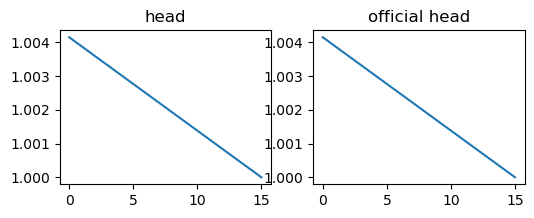

In [3]:
head = flopy.utils.binaryfile.HeadFile(model_ws+'/'+model_name+".hds").get_alldata()
head_official = flopy.utils.binaryfile.HeadFile("./official_examples/ex13_pht3d/mf2k/heads.dat").get_alldata()

plt.figure(figsize=(6,2))
plt.subplot(121)
plt.plot(head[-1, 0, 0])
plt.title("head")
plt.subplot(122)
plt.plot(head_official[-1, 0, 0])
plt.title("official head")

print("R2 score: ", r2_score(np.ravel(head_official), np.ravel(head)))

In [4]:
## Create PHT3D Reactive Transport Model, supported by PHT3D-FSP
## Define "spec", calling PHT3D-FSP (adopt function variables as needed)
spec = pht3d_fsp.create(
    xlsx_path="./", 
    xlsx_name=f"./data/{data_folder}/pht3d_species.xlsx",
    nlay=nlay, 
    nrow=nrow, 
    ncol=ncol,
    ph_os=2,
    ph_temp=7,
    ph_asbin=1,
    ph_eps_aqu=1e-10,
    ph_ph=0.001,
    # ph_print=0,
    ph_cb_offset=0,
    ph_surf_calc_type="  ",
    write_ph="yes"
)
# Move the pht3d_ph.dat file into the models_folder
source = 'pht3d_ph.dat'
destination = os.path.join(model_ws, 'pht3d_ph.dat')
shutil.move(source, destination)

'./models_folder/case13\\pht3d_ph.dat'

In [5]:
spec["xex"] = np.load("./data/case13/init_X_ex.npy")
spec["yaex"] = np.load("./data/case13/init_Y_ex.npy")
spec["ybex"] = np.load("./data/case13/init_Y_ex.npy")
spec["ycex"] = np.load("./data/case13/init_Y_ex.npy")
spec["ydex"] = np.load("./data/case13/init_Y_ex.npy")
spec["yeex"] = np.load("./data/case13/init_Y_ex.npy")
spec["yfex"] = np.load("./data/case13/init_Y_ex.npy")

In [6]:
# # delete single -Formula
# input_file = model_ws+'/pht3d_ph.dat'

# with open(input_file, 'r') as file:
#     lines = file.readlines()
# lines = [line for line in lines if line.strip() != '-Formula']
# with open(input_file, 'w') as file:
#     file.writelines(lines)

In [7]:
# Define SSM and RCH data (for the SSM package) for each stress period
ssm_data = {}
itype = flopy.mt3d.Mt3dSsm.itype_dict() # ... to check the key words
# print(itype)
# {'CHD': 1, 'BAS6': 1, 'PBC': 1, 'WEL': 2, 'DRN': 3, 'RIV': 4, 'GHB': 5, 'MAS': 15, 'CC': -1}

wel_spec={}

for i in range(1):
    for key in spec.keys():
        wel_spec[key]=spec[key][0,0,0]

    wel_spec['c4'] = 0.000001
    wel_spec['cf4'] = 0.0
    wel_spec['ca'] = 0.000001
    wel_spec['cl'] = 0.005301
    wel_spec['fe2'] = 0.00000001
    wel_spec['fe3'] = 0.0
    wel_spec['mg'] = 0.00265
    wel_spec['o0'] = 0.3491
    wel_spec['sf2'] = 0
    wel_spec['s6'] = 1e-08

    wel_spec['ph'] = 7
    wel_spec['pe'] = 15.8715

    wel_spec['orgcsed'] = 0
    wel_spec['goethite'] = 0
    wel_spec['xex'] = 0
    wel_spec['yaex'] = 0
    wel_spec['ybex'] = 0
    wel_spec['ycex'] = 0
    wel_spec['ydex'] = 0
    wel_spec['yeex'] = 0
    wel_spec['yfex'] = 0
    wel_spec['hfow'] = 0
    wel_spec['calcite'] = 0
    wel_spec['pyrite'] = 0

    ssm_per=[0,0,0,0.0,itype['WEL']]
    for key in spec.keys():
        ssm_per.append(wel_spec[key])
    
    ssm_data[i] = ssm_per

for i in range(1, 2):
    for key in spec.keys():
        wel_spec[key]=spec[key][0,0,0]

    wel_spec['c4'] = 0.0000001
    wel_spec['cf4'] = 0.0
    wel_spec['ca'] = 0.0000001
    wel_spec['cl'] = 0.0102
    wel_spec['fe2'] = 1e-08
    wel_spec['fe3'] = 0.0
    wel_spec['mg'] = 0.0051
    wel_spec['o0'] = 1.145E-06
    wel_spec['sf2'] = 0
    wel_spec['s6'] = 0.0000002

    wel_spec['ph'] = 7
    wel_spec['pe'] = 14.5

    wel_spec['orgcsed'] = 0
    wel_spec['goethite'] = 0
    wel_spec['xex'] = 0
    wel_spec['yaex'] = 0
    wel_spec['ybex'] = 0
    wel_spec['ycex'] = 0
    wel_spec['ydex'] = 0
    wel_spec['yeex'] = 0
    wel_spec['yfex'] = 0
    wel_spec['hfow'] = 0
    wel_spec['calcite'] = 0
    wel_spec['pyrite'] = 0

    ssm_per=[0,0,0,0.0,itype['WEL']]
    for key in spec.keys():
        ssm_per.append(wel_spec[key])
    
    ssm_data[i] = ssm_per

ssm_data

{0: [0,
  0,
  0,
  0.0,
  2,
  1e-06,
  0.0,
  1e-06,
  0.005301,
  1e-08,
  0.0,
  0.00265,
  0.3491,
  0,
  1e-08,
  7,
  15.8715,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 1: [0,
  0,
  0,
  0.0,
  2,
  1e-07,
  0.0,
  1e-07,
  0.0102,
  1e-08,
  0.0,
  0.0051,
  1.145e-06,
  0,
  2e-07,
  7,
  14.5,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [8]:
model_name = "case13_mt3dms"
icbund = np.abs(ibound)

## Initiate model object
mt = flopy.mt3d.Mt3dms(model_name, model_ws=model_ws, exe_name='./bin/mt3dms',
                      ftlfilename='mt3d_link.ftl',modflowmodel=model, namefile_ext='nam_pht3d')

prsity = 0.376
save_times = np.array([0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5000001, .5500001, .6000001, .6500001, .7000001, .7500001, .8000001, .8500001, .9000002, .9500002, 1, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 1.55, 1.6, 1.649999, 1.699999, 1.749999, 1.799999, 1.849999, 1.899999, 1.949999, 1.999999, 2.049999, 2.099999, 2.149999, 2.199999, 2.249999, 2.299999, 2.349999, 2.391666])

exec(f'btn = flopy.mt3d.Mt3dBtn(mt, \
                                nper=nper, perlen=perlen, nstp=nstp, dz=2.874E-03, \
                                nlay=nlay, ncol=ncol, nrow=nrow, \
                                laycon=[1], prsity=prsity, icbund=icbund, nprs=1, mxstrn=50000, tsmult=1, timprs=save_times, \
    ncomp={pht3d_fsp.create.ncomp}, mcomp={pht3d_fsp.create.mcomp}, {pht3d_fsp.create.sconc_btn})') # call BTN package in this way to invoke PHT3D-FSP variables

adv = flopy.mt3d.Mt3dAdv(mt, mixelm=-1, percel=0.75, mxpart=5000, nadvfd=0)
dsp = flopy.mt3d.Mt3dDsp(mt, al=0.00537, trpt=0.1, trpv=0.1, multiDiff=True, dmcoef=0.0,)
gcg = flopy.mt3d.Mt3dGcg(mt, isolve=1, cclose=0.00001)
exec(f'ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data, mxss=1000)')
mt.write_input()

DSP: setting dmcoef for component 2 to zero, kwarg name dmcoef2
DSP: setting dmcoef for component 3 to zero, kwarg name dmcoef3
DSP: setting dmcoef for component 4 to zero, kwarg name dmcoef4
DSP: setting dmcoef for component 5 to zero, kwarg name dmcoef5
DSP: setting dmcoef for component 6 to zero, kwarg name dmcoef6
DSP: setting dmcoef for component 7 to zero, kwarg name dmcoef7
DSP: setting dmcoef for component 8 to zero, kwarg name dmcoef8
DSP: setting dmcoef for component 9 to zero, kwarg name dmcoef9
DSP: setting dmcoef for component 10 to zero, kwarg name dmcoef10
DSP: setting dmcoef for component 11 to zero, kwarg name dmcoef11
DSP: setting dmcoef for component 12 to zero, kwarg name dmcoef12


In [9]:
# Manually add the PHC reaction package to the nam file and push out as pht3d.nam
s='PHC               39  pht3d_ph.dat\n'
namfiletxt=open(model_ws + '/'+ mt.namefile, 'r').read()
pht3d_nam = namfiletxt+s
file = open(model_ws + '/pht3d.nam','w')
file.write(pht3d_nam)
file.close()

In [10]:
copy_pht3d_datab(source_folder=data_folder)

run_pht3d_program(work_dir=data_folder)

The file pht3d_datab.dat has been copied to the model folder.
 PHT3D - [Version 2.10]
 Reactive Multicomponent Transport based on MT3DMS and PHREEQC-2.
 Developed by Henning Prommer / Vincent Post

 Using NAME File: pht3d.nam                                         

 STRESS PERIOD NO.    1
 Calling PHREEQC to equilibrate SSM solutions

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO   0.14583E-01

 Transport Step:    1   Step Size:   0.000     Total Elapsed Time:   0.0000    
 Transport Step:    2   Step Size:  1.1187E-02 Total Elapsed Time:  1.11874E-02
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3329      [K,I,J]    1    1   16
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7855E-01  [K,I,J]    1    1   15
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2920E-01  [K,I,J]    1    1   15
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1298E-01  [K,I,J]    1    1   14
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.5194E-02  [K,I,J]    1    1   13
 Outer Iter.  1  Inner Iter.  6:  Max

In [11]:
# Measured data
appelo98 = np.loadtxt('./data/case13/obs_data.txt')
vol_ml = appelo98[:, 0]
mg_meas = appelo98[:, 1]
ca_meas = appelo98[:, 2]
hco3_meas = appelo98[:, 3]
cl_meas = appelo98[:, 4]
so4_meas = appelo98[:, 5]
ph_meas = appelo98[:, 6]

In [12]:
results_cl = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D004.UCN').get_alldata()
results_s6 = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D010.UCN').get_alldata()
results_mg = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D007.UCN').get_alldata()
results_hco3 = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D001.UCN').get_alldata()
results_ph = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D011.UCN').get_alldata()
results_ca = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D003.UCN').get_alldata()

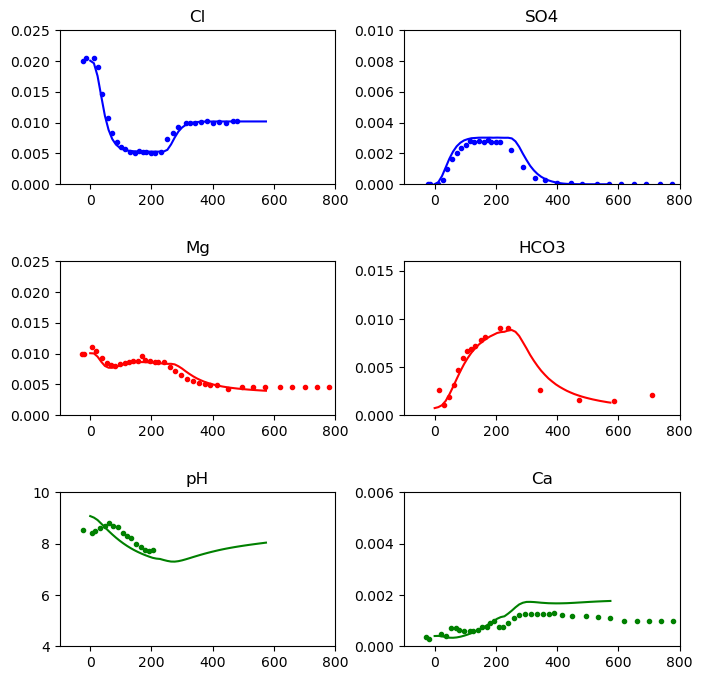

In [13]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(3, 2, 1)
ax.plot(save_times*240, results_cl[1:, 0, 0, -1], color="b")
ax.plot(vol_ml[cl_meas > -9999], cl_meas[cl_meas > -9999], 'b.')
ax.set_title("Cl")
ax.set_xlim(-100, 800)
ax.set_ylim(0, 0.025)

ax = fig.add_subplot(3, 2, 2)
ax.plot(save_times*240, results_s6[1:, 0, 0, -1], color="b")
ax.plot(vol_ml[so4_meas > -9999], so4_meas[so4_meas > -9999], 'b.')
ax.set_title("SO4")
ax.set_xlim(-100, 800)
ax.set_ylim(0, 0.010)

ax = fig.add_subplot(3, 2, 3)
ax.plot(save_times*240, results_mg[1:, 0, 0, -1], color="r")
ax.plot(vol_ml[mg_meas > -9999], mg_meas[mg_meas > -9999], 'r.')
ax.set_title("Mg")
ax.set_xlim(-100, 800)
ax.set_ylim(0, 0.025)

ax = fig.add_subplot(3, 2, 4)
ax.plot(save_times*240, results_hco3[1:, 0, 0, -1], color="r")
ax.plot(vol_ml[hco3_meas > -9999], hco3_meas[hco3_meas > -9999], 'r.')
ax.set_title("HCO3")
ax.set_xlim(-100, 800)
ax.set_ylim(0, 0.016)

ax = fig.add_subplot(3, 2, 5)
ax.plot(save_times*240, results_ph[1:, 0, 0, -1], color="g")
ax.plot(vol_ml[ph_meas > -9999], ph_meas[ph_meas > -9999], 'g.')
ax.set_title("pH")
ax.set_xlim(-100, 800)
ax.set_ylim(4, 10)

ax = fig.add_subplot(3, 2, 6)
ax.plot(save_times*240, results_ca[1:, 0, 0, -1], color="g")
ax.plot(vol_ml[ca_meas > -9999], ca_meas[ca_meas > -9999], 'g.')
ax.set_title("Ca")
ax.set_xlim(-100, 800)
ax.set_ylim(0, 0.006)

plt.subplots_adjust(top=None, bottom=None, left=None, right=None, hspace=0.5, wspace=0.25)

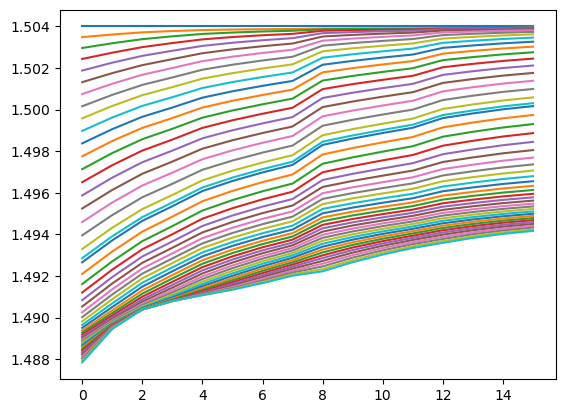

In [14]:
results_calcite = flopy.utils.binaryfile.UcnFile(model_ws+'/PHT3D023.UCN').get_alldata()
results_calcite.shape

for i in range(0, results_calcite.shape[0]):
    plt.plot(results_calcite[i, 0, 0])